# Brief multi-input

## Imports

In [319]:
!pip install keras_nlp
!pip install keras_cv

In [320]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras_nlp
import keras_cv

## Variables

In [321]:
csv_path = r"/content/drive/MyDrive/Briefs simplon/tmp multi-input csv/Flipkart/flipkart_com-ecommerce_sample_1050.csv"
imgs_path  = r"/content/drive/MyDrive/Briefs simplon/tmp multi-input csv/Flipkart/Images/"
img_test_path = r"/content/drive/MyDrive/Briefs simplon/tmp multi-input csv/Flipkart/img_test/montre.jpg"

seed_value = 42
tensorflow.random.set_seed(seed_value)
np.random.seed(seed_value)

pd.options.mode.chained_assignment = None

## Fonctions

In [322]:
def top_x_pred(pred, x=1):
  """Récupère le top 'x' des prédictions"""
  pred_sorted = (-pred).argsort()
  top_x = pred_sorted[0][:x]
  return top_x

def top_pred_name(index):
  """Retourne le nom de la catégorie correspond au cat_label"""
  return classes[index]

def top_x_pred_print(top):
  """Affiche le résultat d'un top 'x' de prédictions avec le nom de la classe et la probabilité"""
  print(f"Top {len(top)} prédiction :")
  for index in top:
    category = classes[index]
    proba = round(pred[0][index] * 100, 2)
    print(f"{category} avec {proba}%")

def load_process_image(img_path):
  """Process les images pour les adapter au format du modèle EfficientNet"""
  img = keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
  return img

def preprocessor_multi(x):
  token_ids, segment_ids = packer(nlp_tokenizer(x))
  x = {
      "token_ids": token_ids,
      "segment_ids": segment_ids,
      "padding_mask": token_ids != 0
  }
  return x

## Récupération données et transformation des colonnes

In [323]:
df = pd.read_csv(csv_path)

In [324]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

In [325]:
df.head(1)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."


In [326]:
df["category_name"] = df["product_category_tree"].str.split(r">>", regex=False, expand=True)[0]
df["category_name"] = df["category_name"].str.replace('["', '')

cat_map = {}
classes = {}
for index,value in enumerate(df["category_name"].unique()):
  cat_map[value] = index
  classes[index] = value

df["cat_label"] = df["category_name"].map(cat_map)

df["image_path"] = df["image"].apply(lambda x: imgs_path + x)

In [327]:
df.head(1)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,category_name,cat_label,image_path
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,0,/content/drive/MyDrive/Briefs simplon/tmp mult...


In [328]:
df[["cat_label", "category_name"]].value_counts().sort_values()

,,count
cat_label,category_name,
0,Home Furnishing,150
1,Baby Care,150
2,Watches,150
3,Home Decor & Festive Needs,150
4,Kitchen & Dining,150
5,Beauty and Personal Care,150
6,Computers,150


## Création des sets d'entrainement et de test

In [329]:
X = df[["description", "image_path"]]
y = df["cat_label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed_value, shuffle=True, stratify=y)

## Modèle NLP


### Entrainement du modèle

In [330]:
nlp_tokenizer = keras_nlp.models.Tokenizer.from_preset("bert_tiny_en_uncased")
nlp_preprocessor = keras_nlp.models.TextClassifierPreprocessor.from_preset("bert_tiny_en_uncased")
nlp_classifier = keras_nlp.models.TextClassifier.from_preset("bert_tiny_en_uncased", num_classes=7)

In [331]:
packer = keras_nlp.layers.MultiSegmentPacker(
    start_value=nlp_tokenizer.cls_token_id,
    end_value=nlp_tokenizer.sep_token_id,
    sequence_length=64
)

In [332]:
nlp_classifier.summary()

Preprocessor: "bert_text_classifier_preprocessor_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ bert_tokenizer (BertTokenizer)                                │                       Vocab size: 30,522 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "bert_text_classifier_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ segment_ids (InputLayer)      │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bert_backbone (BertBackbone)  │ [(None, 128), (None,      │       4,385,920 │ padding_mask[0][0],        │
│                               │ None, 128)]               │                 │ segment_ids[0][0],         │
│                               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ classifier_dropout (Dropout)  │ (None, 128)               │               0 │ bert_backbone[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 7)                 │             903 │ classifier_dropout[0][0]   │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 4,386,823 (16.73 MB)

 Trainable params: 4,386,823 (16.73 MB)

 Non-trainable params: 0 (0.00 B)

In [333]:
no_train = nlp_classifier.layers[3].layers[:9]
for layer in no_train:
  layer.trainable = False
nlp_classifier.summary()

Preprocessor: "bert_text_classifier_preprocessor_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ bert_tokenizer (BertTokenizer)                                │                       Vocab size: 30,522 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "bert_text_classifier_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ segment_ids (InputLayer)      │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bert_backbone (BertBackbone)  │ [(None, 128), (None,      │       4,385,920 │ padding_mask[0][0],        │
│                               │ None, 128)]               │                 │ segment_ids[0][0],         │
│                               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ classifier_dropout (Dropout)  │ (None, 128)               │               0 │ bert_backbone[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 7)                 │             903 │ classifier_dropout[0][0]   │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 4,386,823 (16.73 MB)

 Trainable params: 413,959 (1.58 MB)

 Non-trainable params: 3,972,864 (15.16 MB)

In [334]:
X_train_nlp = X_train["description"]
X_test_nlp = X_test["description"]

In [335]:
nlp_classifier.fit(X_train_nlp, y_train, validation_data=(X_test_nlp, y_test), epochs=5)

Epoch 1/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 138s 4s/step - loss: 1.9498 - sparse_categorical_accuracy: 0.1382 - val_loss: 1.9076 - val_sparse_categorical_accuracy: 0.3381
Epoch 2/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 94s 4s/step - loss: 1.8942 - sparse_categorical_accuracy: 0.3035 - val_loss: 1.8377 - val_sparse_categorical_accuracy: 0.4000
Epoch 3/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 140s 3s/step - loss: 1.8259 - sparse_categorical_accuracy: 0.4200 - val_loss: 1.7469 - val_sparse_categorical_accuracy: 0.5381
Epoch 4/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 92s 3s/step - loss: 1.7372 - sparse_categorical_accuracy: 0.5450 - val_loss: 1.6569 - val_sparse_categorical_accuracy: 0.6143
Epoch 5/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 95s 4s/step - loss: 1.6481 - sparse_categorical_accuracy: 0.5904 - val_loss: 1.5589 - val_sparse_categorical_accuracy: 0.6619


### Test du modèle

In [336]:
test_description = "Distinguish yourself with this Maserati men's watch from the Sfida collection, inspired by the Italian brand's most luxurious racing car models. With a radiant design, it features a PVD-coated stainless steel structure in yellow gold. Its 44mm-diameter case features a midnight-blue dial with a range of functions. These include a tachymetric bezel that measures the distance covered over a given time. A chronograph, with a 60-second counter, a 30-minute counter and a 24-hour counter. There's also a date window at 4:30. The hands of this timepiece are coated with a luminescent treatment for better visibility in the dark. The quartz mechanism is covered by a mineral crystal and is water-resistant to 10 ATM."
pred = nlp_classifier.predict([test_description])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 799ms/step


In [337]:
top_3 = top_x_pred(pred, 3)
top_x_pred_print(top_3)

Top 3 prédiction :
Home Decor & Festive Needs  avec 44.63%
Beauty and Personal Care  avec 30.27%
Home Furnishing  avec 26.28%


## Modèle Computer Vision

### Entrainement modèle

In [338]:
cv_classifier = keras_cv.models.ImageClassifier.from_preset("efficientnetv2_b0_imagenet", num_classes=7)

In [339]:
cv_classifier.summary()

Model: "image_classifier_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficient_net_v2b0_backbone          │ (None, None, None, 1280)    │       5,919,312 │
│ (EfficientNetV2Backbone)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ avg_pool (GlobalAveragePooling2D)    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ predictions (Dense)                  │ (None, 7)                   │           8,967 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,928,279 (22.61 MB)

 Trainable params: 5,867,671 (22.38 MB)

 Non-trainable params: 60,608 (236.75 KB)

In [340]:
no_train = cv_classifier.layers[1].layers[:23]
for layer in no_train:
  layer.trainable = False
cv_classifier.summary()

Model: "image_classifier_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficient_net_v2b0_backbone          │ (None, None, None, 1280)    │       5,919,312 │
│ (EfficientNetV2Backbone)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ avg_pool (GlobalAveragePooling2D)    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ predictions (Dense)                  │ (None, 7)                   │           8,967 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,928,279 (22.61 MB)

 Trainable params: 1,965,847 (7.50 MB)

 Non-trainable params: 3,962,432 (15.12 MB)

In [341]:
X_train_cv = X_train["image_path"].apply(load_process_image)
X_train_cv = tensorflow.stack(X_train_cv.to_list())
X_test_cv = X_test["image_path"].apply(load_process_image)
X_test_cv = tensorflow.stack(X_test_cv.to_list())

y_train_cv = tensorflow.keras.utils.to_categorical(y_train, num_classes=7)
y_test_cv = tensorflow.keras.utils.to_categorical(y_test, num_classes=7)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [342]:
cv_classifier.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=1e-5), metrics=["accuracy"])

cv_classifier.fit(X_train_cv, y_train_cv, validation_data=(X_test_cv, y_test_cv), epochs=5)

Epoch 1/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 99s 3s/step - accuracy: 0.1322 - loss: 1.9690 - val_accuracy: 0.1762 - val_loss: 1.9441
Epoch 2/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step - accuracy: 0.1735 - loss: 1.9397 - val_accuracy: 0.2143 - val_loss: 1.9125
Epoch 3/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 88s 3s/step - accuracy: 0.2242 - loss: 1.9064 - val_accuracy: 0.2524 - val_loss: 1.8812
Epoch 4/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 0.2988 - loss: 1.8746 - val_accuracy: 0.3238 - val_loss: 1.8511
Epoch 5/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 86s 3s/step - accuracy: 0.3308 - loss: 1.8505 - val_accuracy: 0.3429 - val_loss: 1.8207


### Test du modèle

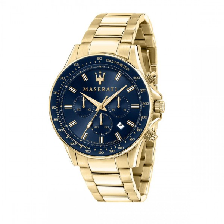

In [343]:
test_image = load_process_image(img_test_path)
test_image

In [344]:
test_image_np = np.expand_dims(test_image, axis=0)
pred = cv_classifier.predict(test_image_np)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


In [345]:
top_3 = top_x_pred(pred, 3)
top_x_pred_print(top_3)

Top 3 prédiction :
Watches  avec 22.41%
Beauty and Personal Care  avec 18.27%
Home Decor & Festive Needs  avec 15.25%


## Multi-input

### Création du modèle à partir des deux autres modèles

In [346]:
display(nlp_classifier.layers)
display(cv_classifier.layers)

[<InputLayer name=padding_mask, built=True>,
 <InputLayer name=segment_ids, built=True>,
 <InputLayer name=token_ids, built=True>,
 <BertBackbone name=bert_backbone, built=True>,
 <Dropout name=classifier_dropout, built=True>,
 <Dense name=logits, built=True>]

[<InputLayer name=input_layer_1, built=True>,
 <EfficientNetV2Backbone name=efficient_net_v2b0_backbone, built=True>,
 <GlobalAveragePooling2D name=avg_pool, built=True>,
 <Dense name=predictions, built=True>]

In [347]:
nlp_model = nlp_classifier.layers[(len(nlp_classifier.layers)-2)].output
cv_model = cv_classifier.layers[(len(cv_classifier.layers)-2)].output

In [348]:
concat_layer = keras.layers.concatenate([nlp_model, cv_model])

In [349]:
dense_layer = keras.layers.Dense(7, activation="softmax")(concat_layer)

In [350]:
multi_model = keras.Model(inputs=[nlp_classifier.input, cv_classifier.input], outputs=dense_layer)

In [351]:
multi_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [352]:
multi_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer) │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ segment_ids (InputLayer)  │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_ids (InputLayer)    │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, None, None, 3)  │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bert_backbone             │ [(None, 128), (None,   │      4,385,920 │ padding_mask[0][0],    │
│ (BertBackbone)            │ None, 128)]            │                │ segment_ids[0][0],     │
│                           │                        │                │ token_ids[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ efficient_net_v2b0_backb… │ (None, None, None,     │      5,919,312 │ input_layer_1[0][0]    │
│ (EfficientNetV2Backbone)  │ 1280)                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ classifier_dropout        │ (None, 128)            │              0 │ bert_backbone[0][0]    │
│ (Dropout)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ avg_pool                  │ (None, 1280)           │              0 │ efficient_net_v2b0_ba… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 1408)           │              0 │ classifier_dropout[0]… │
│ (Concatenate)             │                        │                │ avg_pool[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 7)              │          9,863 │ concatenate_1[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 10,315,095 (39.35 MB)

 Trainable params: 2,379,799 (9.08 MB)

 Non-trainable params: 7,935,296 (30.27 MB)

### Test du modèle

"Distinguish yourself with this Maserati men's watch from the Sfida collection, inspired by the Italian brand's most luxurious racing car models. With a radiant design, it features a PVD-coated stainless steel structure in yellow gold. Its 44mm-diameter case features a midnight-blue dial with a range of functions. These include a tachymetric bezel that measures the distance covered over a given time. A chronograph, with a 60-second counter, a 30-minute counter and a 24-hour counter. There's also a date window at 4:30. The hands of this timepiece are coated with a luminescent treatment for better visibility in the dark. The quartz mechanism is covered by a mineral crystal and is water-resistant to 10 ATM."

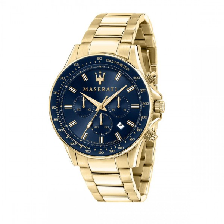

In [353]:
display(test_description)
display(test_image)

In [354]:
description_processed = nlp_preprocessor(test_description)

test_token_np = np.expand_dims(description_processed["token_ids"], axis=0)
test_segment_np = np.expand_dims(description_processed["segment_ids"], axis=0)
test_mask_np = np.expand_dims(description_processed["padding_mask"], axis=0)
test_image_np = np.expand_dims(test_image, axis=0)

In [355]:
pred = multi_model.predict([{
    "token_ids": test_token_np,
    "segment_ids": test_segment_np,
    "padding_mask": test_mask_np
    },
    test_image_np
])

/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: [{'token_ids': 'token_ids', 'segment_ids': 'segment_ids', 'padding_mask': 'padding_mask'}, 'keras_tensor_62']. Received: the structure of inputs=({'token_ids': '*', 'segment_ids': '*', 'padding_mask': '*'}, '*')
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


In [356]:
top_3 = top_x_pred(pred, 3)
top_x_pred_print(top_3)

Top 3 prédiction :
Computers  avec 20.38%
Home Furnishing  avec 16.54%
Kitchen & Dining  avec 16.04%


## Comparaison des modèles

### Récapitulatif des performances et temps entrainement des modèles NLP et CV

Concernant le modèle de NLP :
- Temps d'entrainement : 9 min pour 5 epoch
- Métrique val_sparse_categorical_accuracy : 0.662

Concernant le modèle de CV :
- Temps d'entrainement : 7 min pour 5 epoch
- Métrique val_accuracy : 0.343

### Comparaison des performances sur le test set

In [357]:
df_X_test_nlp_multi = X_test_nlp.apply(preprocessor_multi).apply(pd.Series)
for column in df_X_test_nlp_multi.columns:
  df_X_test_nlp_multi[column] = tensorflow.convert_to_tensor(df_X_test_nlp_multi[column].to_list())

In [358]:
pred_multi = multi_model.predict([
    df_X_test_nlp_multi["token_ids"],
    df_X_test_nlp_multi["segment_ids"],
    df_X_test_nlp_multi["padding_mask"],
    X_test_cv
])

pred_nlp = nlp_classifier.predict(X_test_nlp)

pred_cv = cv_classifier.predict(X_test_cv)

/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: [{'token_ids': 'token_ids', 'segment_ids': 'segment_ids', 'padding_mask': 'padding_mask'}, 'keras_tensor_62']. Received: the structure of inputs=('*', '*', '*', '*')
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


6/7 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 847ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step


In [359]:
serie_true_category = y_test.reset_index(drop=True).map(classes)
serie_pred_multi = pd.Series(pred_multi.tolist()).apply(lambda x: np.argmax(x)).map(classes)
serie_pred_nlp = pd.Series(pred_nlp.tolist()).apply(lambda x: np.argmax(x)).map(classes)
serie_pred_cv = pd.Series(pred_cv.tolist()).apply(lambda x: np.argmax(x)).map(classes)

In [360]:
df_pred = pd.DataFrame({"true_category": serie_true_category, "pred_multi": serie_pred_multi, "pred_nlp": serie_pred_nlp, "pred_cv": serie_pred_cv})

In [361]:
df_pred

,true_category,pred_multi,pred_nlp,pred_cv
0,Home Furnishing,Beauty and Personal Care,Home Furnishing,Baby Care
1,Baby Care,Beauty and Personal Care,Baby Care,Baby Care
2,Kitchen & Dining,Beauty and Personal Care,Home Decor & Festive Needs,Kitchen & Dining
3,Baby Care,Beauty and Personal Care,Baby Care,Watches
4,Baby Care,Beauty and Personal Care,Baby Care,Watches
...,...,...,...,...
205,Home Decor & Festive Needs,Beauty and Personal Care,Home Decor & Festive Needs,Computers
206,Kitchen & Dining,Beauty and Personal Care,Kitchen & Dining,Beauty and Personal Care
207,Home Furnishing,Beauty and Personal Care,Home Furnishing,Home Furnishing
208,Baby Care,Beauty and Personal Care,Baby Care,Beauty and Personal Care


In [362]:
accuracy_multi = (df_pred["true_category"] == df_pred["pred_multi"]).sum() / len(df_pred)
accuracy_nlp = (df_pred["pred_nlp"] == df_pred["true_category"]).sum() / len(df_pred)
accuracy_cv = (df_pred["pred_cv"] == df_pred["true_category"]).sum() / len(df_pred)

In [363]:
print("Précision des modèles sur le dataset de test :")
print(f"Modèle multi-input : {round(accuracy_multi, 3)}")
print(f"Modèle NLP : {round(accuracy_nlp, 3)}")
print(f"Modèle CV : {round(accuracy_cv, 3)}")

Précision des modèles sur le dataset de test :
Modèle multi-input : 0.124
Modèle NLP : 0.662
Modèle CV : 0.343


In [364]:
print("Modèle Multi")
print(classification_report(df_pred["true_category"], df_pred["pred_multi"]))
print("Modèle NLP")
print(classification_report(df_pred["true_category"], df_pred["pred_nlp"]))
print("Modèle CV")
print(classification_report(df_pred["true_category"], df_pred["pred_cv"]))

Modèle Multi
                             precision    recall  f1-score   support

                 Baby Care        0.00      0.00      0.00        30
  Beauty and Personal Care        0.14      0.70      0.23        30
                 Computers        0.09      0.10      0.09        30
Home Decor & Festive Needs        0.00      0.00      0.00        30
           Home Furnishing        0.00      0.00      0.00        30
          Kitchen & Dining        0.00      0.00      0.00        30
                   Watches        0.10      0.07      0.08        30

                   accuracy                           0.12       210
                  macro avg       0.05      0.12      0.06       210
               weighted avg       0.05      0.12      0.06       210

Modèle NLP
                             precision    recall  f1-score   support

                 Baby Care        0.71      0.50      0.59        30
  Beauty and Personal Care        0.47      0.77      0.58        30
      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
